# **Extracting Topic model by  "Latent Dirichlet Allocation (LDA)"  of kepler's book: "Astronomia Nova** "
<font size="4">
This notebook demonstrates how to **extract topics **  from documents, corpus, book. We visualize the result in an informative way. Here, an unsupervised learning model LDA is used. **Topic modelling** is based on the basic assumptions that each corpus (book)  consists of different topics and each topic consists of a collection of words.
<font/>


### Import the required tools 

In [43]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import collections
import os
import logging
import warnings
from itertools import permutations
from sklearn.metrics import make_scorer,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import sklearn_crfsuite  # to install this package in windows with pip please run: 'pip install sklearn-crfsuite'
from sklearn_crfsuite import metrics, scorers
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import eli5  # to install this package in windows with conda please run: 'conda install -c conda-forge eli5'
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from gensim import corpora, models  #  to install this package in windows with conda please run: 'models conda install -c conda-forge gensim'
nltk.download('wordnet')
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\moha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\moha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Please download the data '01_df_v013.pickle' in github on  your local machine from  this directory: vorlesung2019/notebooks/yeghaneh/data

In [8]:
importVersion = '013'  # The  desired version pickle-file of your data (now we are working on version 013 of our data)

In [9]:
path = r'C:\Users\moha\Documents\BZML\01_df_v{0}.pickle'.format(importVersion)  # Put the path of the data in your local machine here, consider the letter "r" before the path

### Let's use data "01_df_v013" to build a NER system. 
<font size="3">The data 01_df_v013 is annotated (labeled) data of english version of well-known kepler's book: New Astronomy (Latin: Astronomia nova). You can find that in the repository.
             </font>


## **Read the data** 
<font size="3">The data  is saves as a pickle file. We read it as a pandas dataFrame. </font>

In [10]:

dfAstroNova = pd.read_pickle(path)  # Put the path of the data in your local machine here, consider the letter "r" before the path

<font size="4"> Sort the data based on the chapters of the book 
</font>

In [11]:
dfAstroNova['chapter'] = dfAstroNova.chapter.replace("appendix b",np.nan).astype(float)  
dfAstroNova.sort_values(by='chapter' , inplace=True)
dfAstroNova.chapter.fillna('appendix b', inplace=True)

In [12]:
len(dfAstroNova)   # Number of rows.

1605

In [13]:
dfAstroNova.head(5)  

,html,text,links,italic,chapter,graphic,table,marginal,sentences,tagged
18,"<p><span class=""anchor"" id=""bookmark0""></span>...",Chapter 1,[],[],1,[],[],[],[Chapter 1],"[[(Chapter, None), (1, NUM)]]"
34,"<p>But before that, I shall prove in this firs...","But before that, I shall prove in this first p...",[],[],1,[],[],[],"[But before that, I shall prove in this first ...","[[(But, None), (before, None), (that, None), (..."
33,<p>But since the sun's mean and apparent motio...,But since the sun's mean and apparent motions*...,[],"[Mysterium cosmographicum,]",1,[],[],[ Terms: * The sun's apparent position is that...,[But since the sun's mean and apparent motions...,"[[(But, None), (since, None), (the, None), (su..."
32,<p>Now the causes and measures of these inequa...,Now the causes and measures of these inequalit...,[],[],1,[],[],[ 5],[Now the causes and measures of these inequali...,"[[(Now, None), (the, None), (causes, None), (a..."
30,"<p>Again, however, it was noticed that these l...","Again, however, it was noticed that these loop...",[],[],1,[],[],[],"[Again, however, it was noticed that these loo...","[[(Again, None), (however, None), (it, None), ..."


In [14]:
dfAstroNova[740:745]

,html,text,links,italic,chapter,graphic,table,marginal,sentences,tagged
594,"<p><span class=""anchor"" id=""bookmark1""></span>...","Whether the motion from the sun, like its ligh...",[{'#fn1': 'άντίφραχις.↩'}],[],35,[],[],[],"[Whether the motion from the sun, like its lig...","[[(Whether, None), (the, None), (motion, None)..."
596,"<p>And concerning the first, it is worthy of c...","And concerning the first, it is worthy of cons...",[],[],35,[],[],[],"[And concerning the first, it is worthy of con...","[[(And, None), (concerning, None), (the, None)..."
595,<p>This is a good time for me to take up the o...,This is a good time for me to take up the obje...,[],[species],35,[],[],[],[This is a good time for me to take up the obj...,"[[(This, None), (is, None), (a, None), (good, ..."
598,"<p>But it is answered, first, that the analogy...","But it is answered, first, that the analogy be...",[],[],35,[],[],[],"[But it is answered, first, that the analogy b...","[[(But, None), (it, None), (is, None), (answer..."
599,<p>On this account I would nearly separate lig...,On this account I would nearly separate light ...,[],[],35,[],[],[],[On this account I would nearly separate light...,"[[(On, None), (this, None), (account, None), (..."


In [15]:
dfAstroNova[1585:1590]

,html,text,links,italic,chapter,graphic,table,marginal,sentences,tagged
1568,<p>{marginal: The words of the observation hav...,Consider whether the meaning could be this: t...,[],[],70,[],[],[ The words of the observation have their comm...,[Consider whether the meaning could be this: t...,"[[(Consider, None), (whether, None), (the, Non..."
1569,<p>This interpretation is furthered by the obs...,This interpretation is furthered by the observ...,[],[],70,[],[],[],[This interpretation is furthered by the obser...,"[[(This, None), (interpretation, None), (is, N..."
0,<p>Appendix B</p>,Appendix B,[],[],appendix b,[],[],[],[Appendix B],"[[(Appendix, None), (B, None)]]"
1,"<p><span class=""anchor"" id=""bookmark0""></span>...",On the Table of Oppositions in Chapter 15,[],[],appendix b,[],[],[],[On the Table of Oppositions in Chapter 15],"[[(On, None), (the, None), (Table, None), (of,..."
2,"<p>by Yaakov Zik <span style=""font-variant: sm...",by Yaakov Zik Table i:,[],[],appendix b,[],[],[],[by Yaakov Zik Table i:],"[[(by, None), (Yaakov, None), (Zik, None), (Ta..."


In [16]:
dfAstroNova.tail(5)

,html,text,links,italic,chapter,graphic,table,marginal,sentences,tagged
13,<p>{table: appendix B t 2}</p>,,[],[],appendix b,[],[ appendix B t 2],[],[],[]
14,"<p>Kepler's table, for comparison {table: appe...","Kepler's table, for comparison",[],[],appendix b,[],[ appendix B t 3],[],"[Kepler's table, for comparison]","[[(Kepler, None), (s, None), (table, None), (f..."
15,<p>Mars from Earth to be a little greater than...,Mars from Earth to be a little greater than ha...,[{'#fn6': ' Kepler's observations yield topoce...,[],appendix b,[],[],[],[Mars from Earth to be a little greater than h...,"[[(Mars, None), (from, None), (Earth, None), (..."
16,"<p><img height=""300"" src=""media/image1.jpeg"" w...","As shown in Figure 2B, the Sun is assumed to ...",[],[],appendix b,[ appendix b gr 1],[],[],"[As shown in Figure 2B, the Sun is assumed to ...","[[(As, None), (shown, None), (in, None), (Figu..."
17,<p>The Sun moved westward and its longitude de...,The Sun moved westward and its longitude decre...,[],[4<sup>h</sup> 23<sup>m </sup>],appendix b,[],[],[],[The Sun moved westward and its longitude decr...,"[[(The, None), (Sun, None), (moved, None), (we..."


## **Primary Data Exploration**

In [17]:
dfAstroNova["text"][5]    # 5th row of the data in the format of text 

"The time is measured from midnight; Gregorian dates are obtained by adding 10 days to Kepler's dates. The dates are given in old style."

In [18]:
dfAstroNova["tagged"][5] # 5th row of the data in a format (token, label). A list of lists of tuples! later position tags of the token will be added to each tuple. the tokens are chosen before by some rules.

[[('The', 'None'),
  ('time', 'None'),
  ('is', 'None'),
  ('measured', 'None'),
  ('from', 'None'),
  ('midnight', 'None'),
  ('Gregorian', 'None'),
  ('dates', 'None'),
  ('are', 'None'),
  ('obtained', 'None'),
  ('by', 'None'),
  ('adding', 'None'),
  ('10', 'NUM'),
  ('days', 'None'),
  ('to', 'None'),
  ('Kepler', 'None'),
  ('s', 'None'),
  ('dates', 'None')],
 [('The', 'None'),
  ('dates', 'None'),
  ('are', 'None'),
  ('given', 'None'),
  ('in', 'None'),
  ('old', 'None'),
  ('style', 'None')]]

In [19]:
 df = sum(dfAstroNova['tagged'], [])  # Flatt the data by removing first lists
len(df)

6699

In [20]:
df[5]  

[('Copernicus', 'None'),
 ('and', 'None'),
 ('Tycho', 'None'),
 ('followed', 'None'),
 ('Ptolemy', 'None'),
 ('carrying', 'None'),
 ('over', 'None'),
 ('his', 'None'),
 ('assumptions', 'None')]

In [21]:
df_flatten = sum(df,[])  # Flatt the data by removing the second list


In [22]:
df_flatten[0:20]  # Here we have tokens (entities) with their labels

[('Chapter', 'None'),
 ('1', 'NUM'),
 ('But', 'None'),
 ('before', 'None'),
 ('that', 'None'),
 ('I', 'None'),
 ('shall', 'None'),
 ('prove', 'None'),
 ('in', 'None'),
 ('this', 'None'),
 ('first', 'None'),
 ('part', 'None'),
 ('that', 'None'),
 ('one', 'None'),
 ('who', 'None'),
 ('substitutes', 'None'),
 ('the', 'None'),
 ('sun', 'None'),
 ('s', 'None'),
 ('apparent', 'None')]

In [23]:
len(df_flatten)  # Number of all tokens (roughly speaking all words or entities)

169231

In [24]:
tokens = [x[0] for x in df_flatten]  # Extract the tokens for further use in the frequency plot

In [25]:
labels=([x[1] for x in df_flatten])  # Extract the labels for further use in the frequency plot

In [26]:
tokens[0:5]

['Chapter', '1', 'But', 'before', 'that']

In [27]:
labels[0:5]

['None', 'NUM', 'None', 'None', 'None']

## **Visualization**

### Frequency plot of all words in all chapter of book

<font size="3">
Frequency plot of all tokens in text, as you see there is a lot 'the', 'of',... in text, they normally consider as noise, we will back to that later.
<font/>

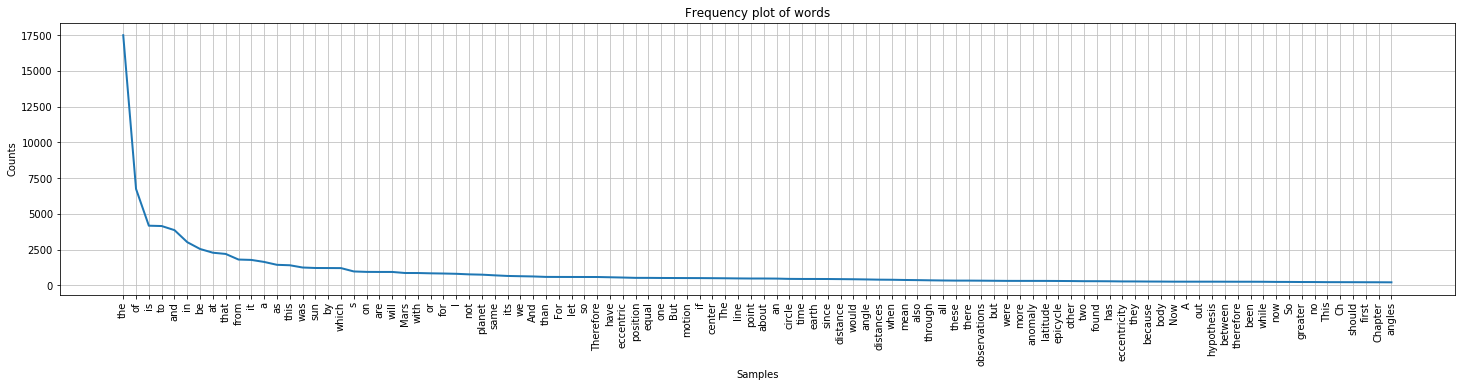

In [28]:
freqdist = nltk.FreqDist(tokens)
plt.figure(figsize=(25,5))
freqdist.plot(100, title='Frequency plot of words')


In [29]:
stop_words=["the", "of", "is", "to", "and","in", "be", "at", "that", "from", "it", "a", "as","this", "was" ] # we can consider these as stop words or we can use nltk stop words.

In [30]:
# nltk stop words
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))
stop_words=stop_words.union(['I', 'And', 'For', 'A', 'The'])
#stop_words_nltk = set(stop_words)

# List of nltk stop words {‘ourselves’, ‘hers’, ‘between’, ‘yourself’, ‘but’, ‘again’, ‘there’, ‘about’, ‘once’, ‘during’, ‘out’, ‘very’, ‘having’, ‘with’, ‘they’, ‘own’, ‘an’, ‘be’, ‘some’, ‘for’, ‘do’, ‘its’, ‘yours’, ‘such’, ‘into’, ‘of’, ‘most’, ‘itself’, ‘other’, ‘off’, ‘is’, ‘s’, ‘am’, ‘or’, ‘who’, ‘as’, ‘from’, ‘him’, ‘each’, ‘the’, ‘themselves’, ‘until’, ‘below’, ‘are’, ‘we’, ‘these’, ‘your’, ‘his’, ‘through’, ‘don’, ‘nor’, ‘me’, ‘were’, ‘her’, ‘more’, ‘himself’, ‘this’, ‘down’, ‘should’, ‘our’, ‘their’, ‘while’, ‘above’, ‘both’, ‘up’, ‘to’, ‘ours’, ‘had’, ‘she’, ‘all’, ‘no’, ‘when’, ‘at’, ‘any’, ‘before’, ‘them’, ‘same’, ‘and’, ‘been’, ‘have’, ‘in’, ‘will’, ‘on’, ‘does’, ‘yourselves’, ‘then’, ‘that’, ‘because’, ‘what’, ‘over’, ‘why’, ‘so’, ‘can’, ‘did’, ‘not’, ‘now’, ‘under’, ‘he’, ‘you’, ‘herself’, ‘has’, ‘just’, ‘where’, ‘too’, ‘only’, ‘myself’, ‘which’, ‘those’, ‘i’, ‘after’, ‘few’, ‘whom’, ‘t’, ‘being’, ‘if’, ‘theirs’, ‘my’, ‘against’, ‘a’, ‘by’, ‘doing’, ‘it’, ‘how’, ‘further’, ‘was’, ‘here’, ‘than’} 


<font size="3">
We can consider these words like 'the', 'of',... as noises. so we temporary remove those! 
<font/>

In [31]:
new_tokens = []     
for w in tokens:
    if w not in stop_words: new_tokens.append(w)      

### Frequency plot of all words in all chapter of book after removing the stop words

<font size="3">
It shows word "sun" is most common word.  We can also see the word Mars, planet, eccentric as common words in the book 
<font/>

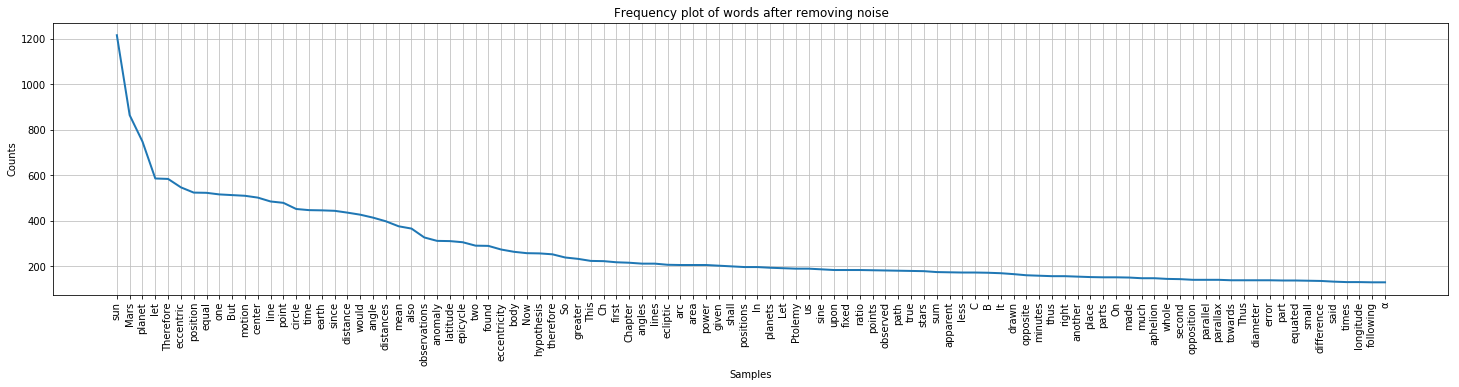

In [32]:
freqdist = nltk.FreqDist(new_tokens) 
plt.figure(figsize=(25,5)) 
freqdist.plot(100, title='Frequency plot of words after removing noise')

<font size="4">
Do we need more insight than frequency plot of word for see content of the book? the question is answered by the follwoing cells through investigation of "topic modelling"
<font/>

## **Topic Modelling by LDA**

 Here you see an structured workflow to build an insightful "topic model" based on the Latent Dirichlet Allocation (LDA) algorithm,  modeled as Dirichlet distributions Dir(α).
 For more detail you can read: <p>
http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf
    </p>

### **Pre-processing**

<font size="3">
Since we alreay tokenized the text (split text into  word without punctuation) and removed stopwrods, we only need to **lemmatize** and **stemm** the tokens.
<font/>

In [34]:
mytext = nltk.Text(new_tokens) 

#### Lemmatization 

<font size="3">
Lemmatization, takes into consideration the morphological analysis of the words. For instance  "do", "does", "did" and "doing" are forms of the same lexeme with "do" as the lemma. Another example would be  "car", "cars", "automobile"
<font/>

In [35]:
#lemmatization
w_lemmatize= WordNetLemmatizer()
my_text_lemmatize = [w_lemmatize.lemmatize(word) for word in mytext]


#### Stemming

<font size="3">
Stemming algorithms work by cutting off the end or the beginning of the word, by taking into account a list of common prefixes and suffixes. It reduces words to their word stem or root form. For instance, stemming for root word "like" include:"likes", "liked", "likely", "liking
<font size=/>

In [36]:
# stemming 
p_stemmers=PorterStemmer()  
my_text_lemm_stemmer = [p_stemmers.stem(word) for word in my_text_lemmatize]

In [37]:
my_text_lemm_stemmer=[my_text_lemm_stemmer] #make a list of list

#### Select a document to preview after preprocessing.

In [38]:
Dic=corpora.Dictionary(my_text_lemm_stemmer)

### **Bag of Words on the Data set**

<font size="4">
Our dictionary must be converted to "bag of word". Frequency of occurrence of each word is used as a feature for training a classifier. It means it should contain the number of times a word appears
<font size>

In [39]:
corpus = [Dic.doc2bow(text) for text in my_text_lemm_stemmer]

#### Running LDA using Bag of Words**

In [44]:
ldamodel =models.ldamodel.LdaModel(corpus, num_topics=3,  id2word = Dic, passes=2)

In [45]:
lda_topics=ldamodel.print_topics()

In [36]:
lda_topics

[(0,
  '0.013*"sun" + 0.010*"distanc" + 0.009*"mar" + 0.009*"therefor" + 0.009*"eccentr" + 0.009*"line" + 0.007*"planet" + 0.007*"let" + 0.007*"observ" + 0.007*"posit"'),
 (1,
  '0.014*"sun" + 0.013*"eccentr" + 0.010*"therefor" + 0.009*"mar" + 0.009*"distanc" + 0.009*"let" + 0.008*"posit" + 0.008*"point" + 0.008*"planet" + 0.007*"equal"'),
 (2,
  '0.014*"sun" + 0.012*"planet" + 0.010*"mar" + 0.010*"observ" + 0.009*"let" + 0.009*"distanc" + 0.009*"therefor" + 0.009*"posit" + 0.008*"line" + 0.008*"motion"'),
 (3,
  '0.011*"planet" + 0.009*"eccentr" + 0.009*"mar" + 0.009*"sun" + 0.008*"therefor" + 0.006*"one" + 0.006*"distanc" + 0.006*"angl" + 0.006*"posit" + 0.006*"observ"')]

In [46]:
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, Dic)
vis

C:\Users\moha\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
2     -0.011234 -0.0       1        1  98.808136
0     -0.001845 -0.0       2        1   1.191406
1      0.013079 -0.0       3        1   0.000458, topic_info=     Category         Freq      Term        Total  loglift  logprob
term                                                               
5981  Default  1221.000000       sun  1221.000000  30.0000  30.0000
4796  Default   841.000000       mar   841.000000  29.0000  29.0000
5269  Default   717.000000     posit   717.000000  28.0000  28.0000
5245  Default   892.000000    planet   892.000000  27.0000  27.0000
3682  Default   793.000000   distanc   793.000000  26.0000  26.0000
5033  Default   696.000000    observ   696.000000  25.0000  25.0000
3762  Default   830.000000   eccentr   830.000000  24.0000  24.0000
6086  Default   849.000000  therefor   849.000000  23.0000  23.0000
4694  Default   665.000000       let   665.000000  22.0000  22.0000
4718  Default   655.000000      line   655.000000  21.0000  21.0000
5258  Default   641.000000     point   641.000000  20.0000  20.0000
4911  Default   634.000000    motion   634.000000  19.0000  19.0000
5073  Default   587.000000       one   587.000000  18.0000  18.0000
2805  Default   616.000000      angl   616.000000  17.0000  17.0000
3872  Default   554.000000     equal   554.000000  16.0000  16.0000
6125  Default   525.000000      time   525.000000  15.0000  15.0000
3269  Default   492.000000     circl   492.000000  14.0000  14.0000
3178  Default   517.000000    center   517.000000  13.0000  13.0000
3099  Default   529.000000       but   529.000000  12.0000  12.0000
4831  Default   409.000000      mean   409.000000  11.0000  11.0000
2776  Default   418.000000      also   418.000000  10.0000  10.0000
6476  Default   413.000000     would   413.000000   9.0000   9.0000
5779  Default   503.000000      sinc   503.000000   8.0000   8.0000
3746  Default   444.000000     earth   444.000000   7.0000   7.0000
3865  Default   310.000000   epicycl   310.000000   6.0000   6.0000
2814  Default   312.000000   anomali   312.000000   5.0000   5.0000
3634  Default   331.000000    differ   331.000000   4.0000   4.0000
4648  Default   359.000000   latitud   359.000000   3.0000   3.0000
2873  Default   309.000000       arc   309.000000   2.0000   2.0000
3202  Default   300.000000   chapter   300.000000   1.0000   1.0000
...       ...          ...       ...          ...      ...      ...
4718   Topic3     0.002376      line   655.298889  -0.2333  -5.0880
4831   Topic3     0.001653      mean   409.903107  -0.1272  -5.4510
4820   Topic3     0.000492   maximum    85.051819   0.2333  -6.6632
5258   Topic3     0.002304     point   641.019775  -0.2424  -5.1191
6476   Topic3     0.001639     would   413.581970  -0.1449  -5.4597
5073   Topic3     0.002107       one   587.168213  -0.2439  -5.2084
6305   Topic3     0.001071       use   244.767120  -0.0459  -5.8853
2776   Topic3     0.001597      also   418.099670  -0.1813  -5.4853
2814   Topic3     0.001279   anomali   312.604218  -0.1125  -5.7073
6224   Topic3     0.000846         u   181.423477   0.0180  -6.1208
6093   Topic3     0.000907       thi   198.773849  -0.0039  -6.0514
5162   Topic3     0.001194      part   286.775909  -0.0948  -5.7758
4796   Topic3     0.002702       mar   841.454773  -0.3548  -4.9594
4717   Topic3     0.000487     limit    90.049217   0.1667  -6.6727
3682   Topic3     0.002510   distanc   793.128418  -0.3696  -5.0334
3269   Topic3     0.001753     circl   492.005554  -0.2512  -5.3924
5893   Topic3     0.001111      star   272.525848  -0.1161  -5.8481
3053   Topic3     0.001128      bodi   281.116119  -0.1321  -5.8331
6125   Topic3     0.001787      time   525.545715  -0.2976  -5.3729
3872   Topic3     0.001850     equal   554.970581  -0.3174  -5.3382
4911   Topic3     0.002015    motion   634.471191  -0.3662  -5.2531
2805   Topic3     0.001875      angl   6

In [38]:
pyLDAvis.display(vis) 

In [183]:
pyLDAvis.save_html(vis,'vis.html') # You can open saved html file  (vis_01)in your browser to see the result. 

<font size= "4">
How can we find that how many topics are proper for the model?
<font/>

## **Coherence Metric**